## Project 3: Web APIs & Classification
---
Project notebook organisation:<br>
<a href='./1_Get_and_Clean_Data.ipynb'>1_Get_and_Clean_Data</a><br>
<a href='./2_EDA_and_Preprocessing.ipynb'>2_EDA_and_Preprocessing</a><br>
**3_Models (current notebook)**<br>


---
### This notebook's layout
<a href='#import'>Re-import and and check dataframes</a><br>
<a href='#dummy'>Create dummies and combine data files</a><br>
<a href='#split'>Model Prep: Train/test split</a><br>
<a href='#logit'>Logistic Regression</a><br>
<a href='#models'>Models (Naive Bayes, Logistic Regression, Random Forest)</a><br>
<a href='#cv'>GridSearchCV</a><br>
<a href='#best'>Best Model</a><br>
<a href='#confuse'>Confusion Matrix</a><br>
<a href='#roc'>ROC Curve with AUC</a><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import string
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, Binarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.feature_selection import SelectPercentile, mutual_info_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc

from nltk.corpus import stopwords
import regex as re

%matplotlib inline

<a id='import'></a>
### Re-import and and check dataframes

In [2]:
gold = pd.read_csv('../data/gold_clean.csv')
silver = pd.read_csv('../data/silver_clean.csv')

<a id='dummy'></a>
### Pre-processing before modelling

- Create dummies<br>
- Merge gold and silver, into one as 'combined_metals'<br>
- Create a new column that combines 2 columns together ('title'+'comments')

In [3]:
# create dummy column for target: 
# 1 for r/Gold 
# 0 for r/Silverbugs

gold['subreddit'] = 1
silver['subreddit'] = 0

In [4]:
combined_metals = pd.concat([gold,silver])

In [5]:
combined_metals.shape

(1916, 8)

<a id='split'></a>
### Model Prep: Train/test split

In [6]:
X = combined_metals['title'] + combined_metals['comments']
y = combined_metals[['subreddit']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,random_state=42)

In [8]:
tvec = TfidfVectorizer(stop_words='english', max_features=1000)

In [9]:
X_train = tvec.fit_transform(X_train)
X_test = tvec.transform(X_test)

### Baseline accuracy
Based on value of zero, it would predict correctly silver subreddit at 54% of the time

In [10]:
y_train.subreddit.value_counts(normalize=True)

0    0.543493
1    0.456507
Name: subreddit, dtype: float64

In [11]:
def get_score(model):
    """Gets train and test score for the model"""
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print("The train score is " + str(train_score))
    print("The test score is " + str(test_score))

<a id='models'></a>
### Models (Naive Bayes, Logistic Regression, Random Forest)

### Naive Bayes

In [12]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
get_score(nb)

The train score is 0.8636047320807237
The test score is 0.7056367432150313


<a id='logit'></a>
### Logistic Regression

In [14]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
# train/test score
get_score(lr)

The train score is 0.8649965205288797
The test score is 0.7473903966597077


### Random Forest

In [16]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
# train/test score
get_score(rf)

The train score is 0.9672929714683368
The test score is 0.7432150313152401


<a id='cv'></a>
### GridSearchCV (Logistics Regression and Random Forest)

In [18]:
# Create grid search using 8-fold cross validation
lr_params = {
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l1', 'l2'],
    'C': np.linspace(0.5, 3 ,8)
}
gs = GridSearchCV(lr, param_grid=lr_params, cv=8)
gs.fit(X_train, y_train)

GridSearchCV(cv=8, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([0.5       , 0.85714286, 1.21428571, 1.57142857, 1.92857143,
       2.28571429, 2.64285714, 3.        ]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=Non

In [19]:
# View best hyperparameters
print('Best Penalty:', gs.best_estimator_.get_params()['penalty'])
print('Best C:', gs.best_estimator_.get_params()['C'])
print('Best Solver:', gs.best_estimator_.get_params()['solver'])

Best Penalty: l2
Best C: 0.8571428571428572
Best Solver: lbfgs


In [20]:
# train/test score
get_score(lr)

The train score is 0.8649965205288797
The test score is 0.7473903966597077


In [21]:
# Create grid search using 8-fold cross validation
rf_params = {
    'n_estimators': [300,400],
    'max_depth': [None, 1],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=8)
gs.fit(X_train, y_train)

GridSearchCV(cv=8, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [22]:
# View best hyperparameters
print(gs.best_score_)
gs.best_params_

0.75368947858473


{'max_depth': None, 'n_estimators': 400}

In [23]:
# train/test score
get_score(rf)

The train score is 0.9672929714683368
The test score is 0.7348643006263048


<a id='best'></a>
### Best model is Logistic Regression

In [24]:
best_lr = LogisticRegression(C=0.8571, penalty='l2', solver='lbfgs')

In [25]:
best_lr.fit(X_train, y_train)

LogisticRegression(C=0.8571, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
get_score(best_lr)

The train score is 0.8559498956158664
The test score is 0.7473903966597077


In [27]:
predictions = best_lr.predict(X_test)

<a id='confuse'></a>
### Confusion Matrix

In [28]:
# print confusion matrix

cmatrix = confusion_matrix(y_test, predictions)
print("Confusion matrix")
pd.DataFrame(cmatrix, 
             index = ['predicted silver','predicted gold'],
             columns = [' actual silver', 'actual gold'])

Confusion matrix


,actual silver,actual gold
predicted silver,229,31
predicted gold,90,129


In [29]:
def model_metrics(model):
    "Get Accuracy, Sensitivity and Specificity for the best model"
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    Accuracy = (tp + tn) / (tp + tn + fp + fn)
    Sensitivity = tp / (tp + fn)
    Specificity = tn / (tn + fp)
    print("Accuracy is " + str(Accuracy))
    print("Sensitivity is "+ str(Sensitivity))
    print("Specificity is " + str(Specificity))

In [30]:
# model
model_metrics(best_lr)

Accuracy is 0.7473903966597077
Sensitivity is 0.589041095890411
Specificity is 0.8807692307692307


<a id='roc'></a>
### ROC Curve with AUC

In [31]:
# Removes index from y_test, so there will be no conflict when forming pred_df
y_test = y_test['subreddit']

In [32]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [33]:
from sklearn.metrics import roc_auc_score

In [34]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8125570776255708

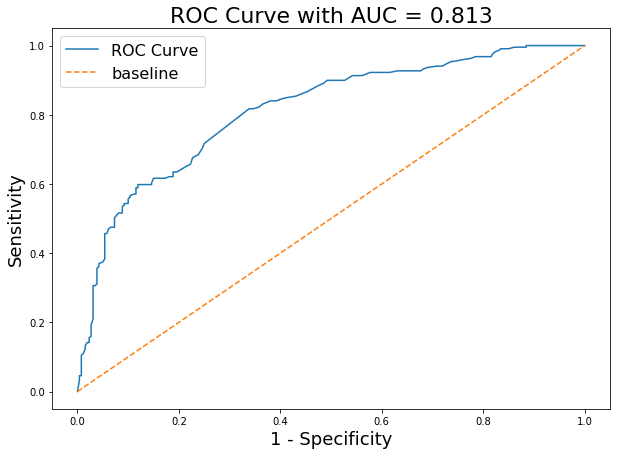

In [35]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);